In [19]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extraer_solapamientos(path_metrics):
    with open(path_metrics, 'r', encoding='utf-8') as f:
        contenido = f.read()

    bloque = re.search(r'Distribución por rangos de solapamiento:\s*-+\n(.+?)(\n\n|\Z)', contenido, re.DOTALL)
    if not bloque:
        return None

    distribucion = {}
    for linea in bloque.group(1).strip().split('\n'):
        match = re.match(r'\s*(\d+-\d+%)\:\s+(\d+)', linea)
        if match:
            rango, cantidad = match.groups()
            distribucion[rango] = int(cantidad)

    return distribucion

# Recorre todo el árbol de directorios
base_dir = 'errores'
datos = []

for modo in ['no_tags', 'with_tags']:
    dir_modo = os.path.join(base_dir, f'{modo}')
    for carpeta in sorted(os.listdir(dir_modo)):
        if not carpeta.startswith('margin_'):
            continue
        margen_str = carpeta.replace('margin_', '').replace('_', '.')
        margen = float(margen_str)
        path_metrics = os.path.join(dir_modo, carpeta, 'metrics_prompt8.txt')
        if os.path.exists(path_metrics):
            dist = extraer_solapamientos(path_metrics)
            if dist:
                for rango, count in dist.items():
                    datos.append({
                        'modo': modo,
                        'margen': margen,
                        'rango': rango,
                        'count': count
                    })

df = pd.DataFrame(datos)
df.sort_values(by=['modo', 'margen'], inplace=True)


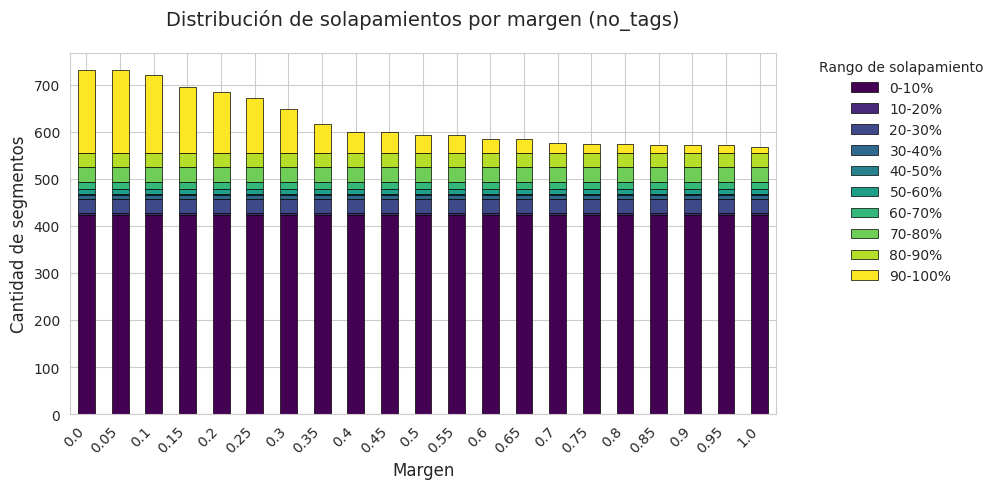

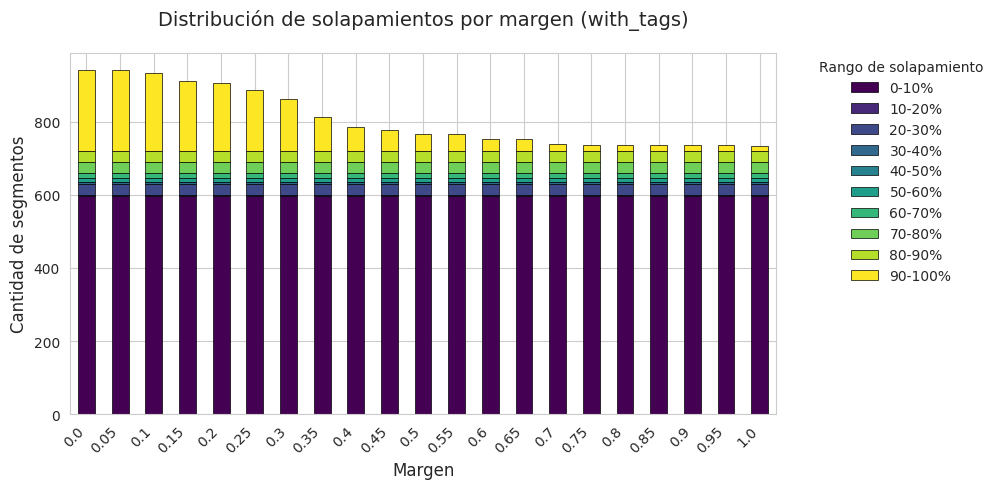

In [20]:
for modo in ['no_tags', 'with_tags']:
    df_modo = df[df['modo'] == modo]
    pivot_df = df_modo.pivot_table(index='margen', columns='rango', values='count', fill_value=0)
    pivot_df.sort_index(inplace=True)  # Ordenar por margen

    # Crear el gráfico
    ax = pivot_df.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 5),
        colormap='viridis',  # Paleta de colores
        edgecolor='black',   # Borde de las barras
        linewidth=0.5
    )

    # Personalización
    plt.title(f"Distribución de solapamientos por margen ({modo})", fontsize=14, pad=20)
    plt.ylabel("Cantidad de segmentos", fontsize=12)
    plt.xlabel("Margen", fontsize=12)
    plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje X

    # Leyenda fuera del gráfico (a la derecha)
    plt.legend(
        title='Rango de solapamiento',
        bbox_to_anchor=(1.05, 1),  # Posición (x, y) relativa al gráfico
        loc='upper left',           # Punto de anclaje de la leyenda
        borderaxespad=0.1,          # Espacio entre leyenda y gráfico
        frameon=False               # Sin marco alrededor
    )

    # Ajustar márgenes para evitar cortes
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # rect=[left, bottom, right, top]
    plt.show()

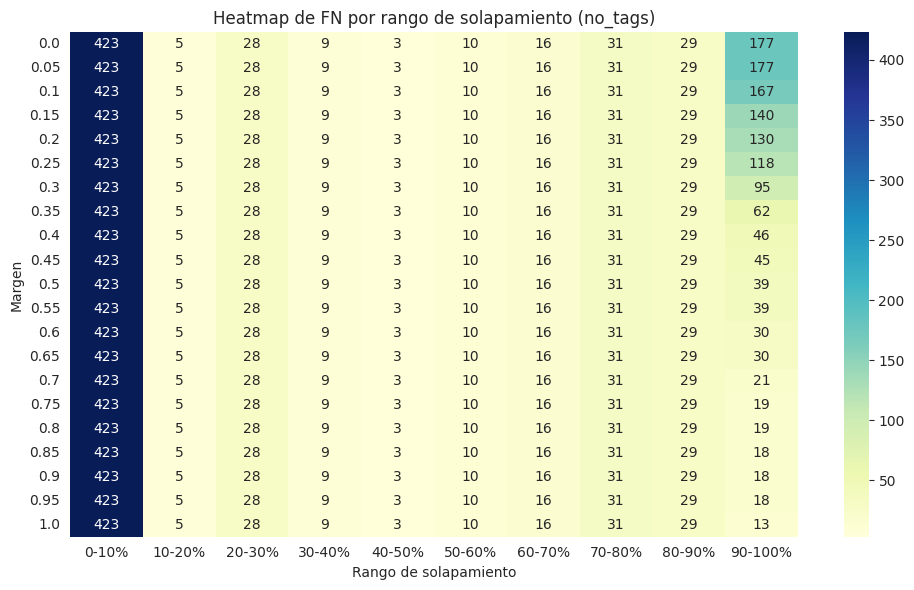

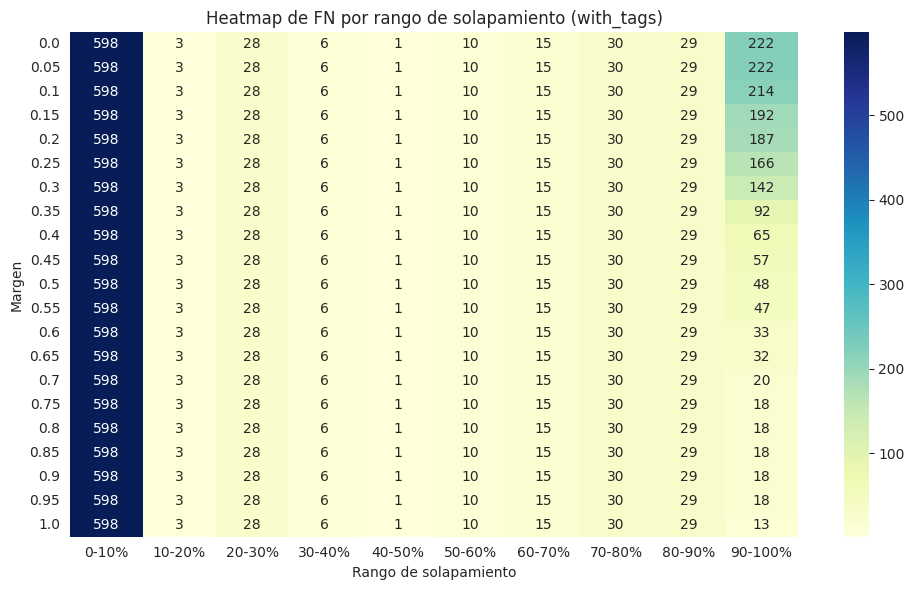

In [21]:
for modo in ['no_tags', 'with_tags']:
    df_modo = df[df['modo'] == modo]
    heatmap_df = df_modo.pivot_table(index='margen', columns='rango', values='count', aggfunc='sum', fill_value=0)
    heatmap_df = heatmap_df.sort_index()

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Heatmap de FN por rango de solapamiento ({modo})")
    plt.ylabel("Margen")
    plt.xlabel("Rango de solapamiento")
    plt.tight_layout()
    plt.show()


In [22]:
import matplotlib.pyplot as plt
import re
import os

def graficar_metricas_desde_txt(path_txt):
    with open(path_txt, "r", encoding="utf-8") as f:
        contenido = f.read()

    # Extraer nombre de la subcarpeta (segunda parte del path)
    partes_path = os.path.normpath(path_txt).split(os.sep)
    if len(partes_path) < 2:
        nombre_subcarpeta = "desconocido"
    else:
        nombre_subcarpeta = partes_path[-2]

    # Extraer métricas agregadas
    precision = float(re.search(r"Precision:\s+([\d.]+)", contenido).group(1))
    recall = float(re.search(r"Recall:\s+([\d.]+)", contenido).group(1))
    f1 = float(re.search(r"F1-score:\s+([\d.]+)", contenido).group(1))

    # Extraer distribución de FN por rango
    bloques = re.findall(r"([\d%-]+):\s+(\d+)", contenido.split("Distribución por rangos")[1])
    rangos = [r[0] for r in bloques]
    valores_abs = [int(r[1]) for r in bloques]
    total_fn = sum(valores_abs)
    valores_pct = [v / total_fn * 100 for v in valores_abs]

    # Filtrar valores 0 para evitar ruido visual
    rangos_filtrados = [r for r, v in zip(rangos, valores_abs) if v > 0]
    valores_pct_filtrados = [v for v in valores_pct if v > 0]

    # Gráfico 1: FN por solapamiento (en %)
    plt.figure(figsize=(10, 5))
    barras = plt.bar(rangos_filtrados, valores_pct_filtrados, color='steelblue')
    plt.title(f"Distribución de FN – {nombre_subcarpeta}")
    plt.xlabel("Rango de solapamiento")
    plt.ylabel("Porcentaje de FN (%)")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for bar, pct in zip(barras, valores_pct_filtrados):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{pct:.1f}%",
                 ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Métricas agregadas
    metricas = {"Precision": precision, "Recall": recall, "F1-score": f1}
    plt.figure(figsize=(6, 3))
    plt.barh(list(metricas.keys()), list(metricas.values()), color='seagreen')
    plt.xlim(0, 1)
    plt.title(f"Métricas – {nombre_subcarpeta}")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


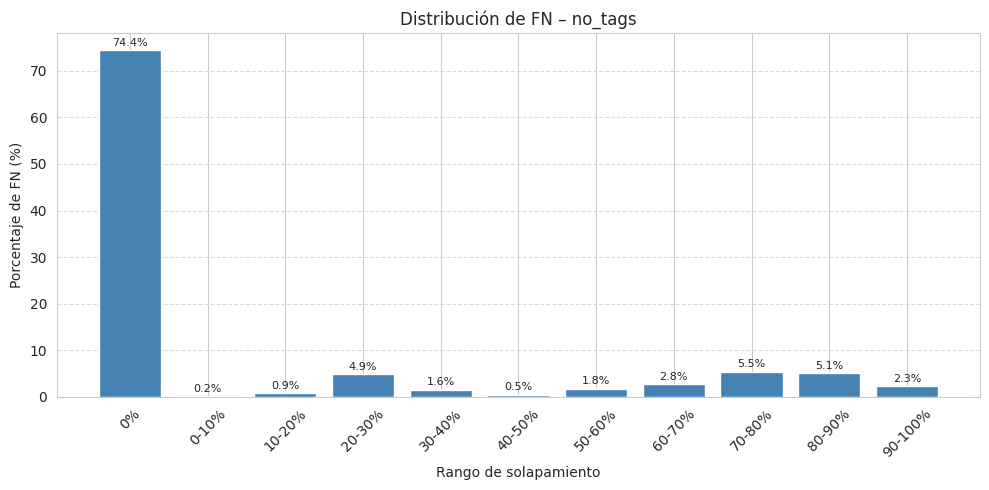

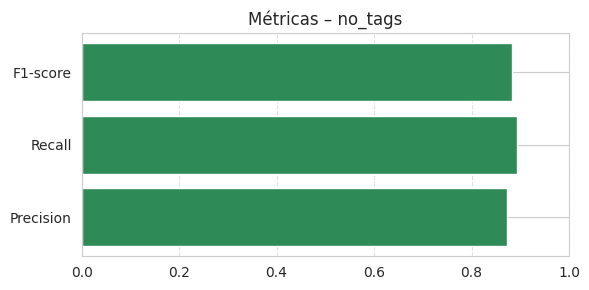

In [23]:
graficar_metricas_desde_txt("errores_noMargen/no_tags/metrics_prompt8.txt")

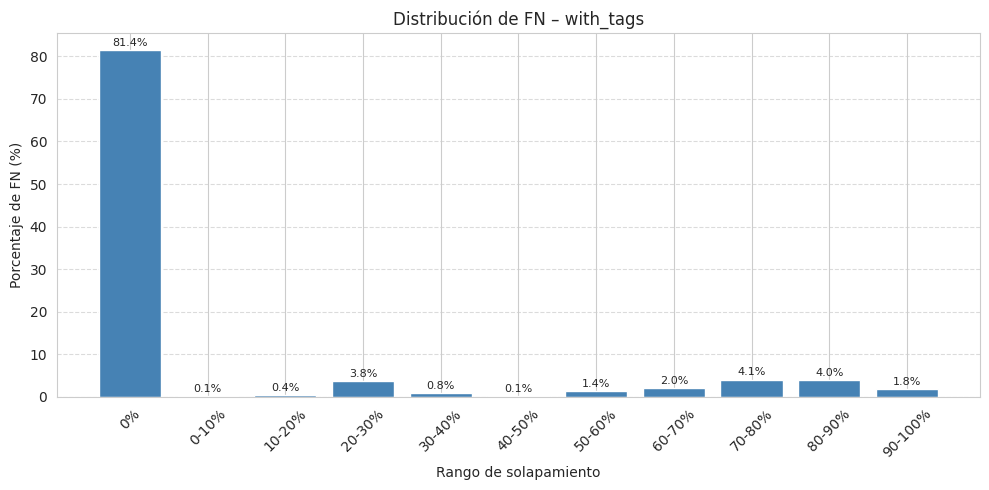

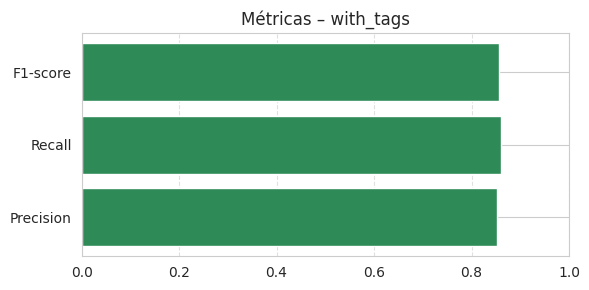

In [24]:
graficar_metricas_desde_txt("errores_noMargen/with_tags/metrics_prompt8.txt")
